In [1]:
# importando pacotes/módulos
# funções para interagir com o sistema operacional
import os
import sys
import subprocess

# confere se dentro do modulos do sistem existe o modulo 'google.colab'
in_colab = 'google.colab' in sys.modules # True se o modulo existe, caso contrario, False
if in_colab:
    # importa a classe/função drive do módulo google.colab
    from google.colab import drive
    # acessa o google drive e o coloca em /content/drive
    drive.mount('/content/drive')
    # muda para a pasta onde temos o repositorio dos códigos
    path = "/content/drive/MyDrive/Shared/tide_prediction_luiscorreia/tide_prediction_luiscorreia"
    os.chdir(path) # chdir => change directory (mudar de pasta)
    # instala o hvplot com o pip (plots interativos)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "hvplot"])

Mounted at /content/drive


In [4]:
import json
# Open the JSON file for reading
with open('data/processed/amplitudes.json', 'r') as fname:
    # Load the contents from the file, which creates a Python dictionary
    amp = json.load(fname)
    # converter de dicionario para lista com [a1, a2, ..., an, b1, b2, ..., bn]
    amplitudes = [amp[k][0] for k in amp] + [amp[k][1] for k in amp]

In [5]:
import numpy as np
from datetime import datetime, timedelta

# data de referência (mesma do tide_fitting.ipynb)
tref = np.datetime64("1960-01-01")
# interpretador de timestamp
parser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

# dicionário que define o período em horas para cada componente de maré
# https://en.wikipedia.org/wiki/Theory_of_tides
tide_constituents = {
    "M2": 12.4206012,
    "S2": 12,
    "N2": 12.65834751,
    "K1": 23.93447213,
    "O1": 25.81933871,
    "M4": 6.210300601,
    "M6": 4.140200401,
    "MK3": 8.177140247,
    "S4": 6,
    "MN4": 6.269173724
}

def estimate_tide(t, *amplitudes, tide_constituents = tide_constituents):
    '''
    Função de estimar a maré, dado o tempo, amplitudes e componentes
    t (numpy.array) => tempo, em horas
    amplitudes (numpy.array/lista) => amplitude de cada componente de maré
    tide_constituents (dicionário) => período, em horas, para cada componente de maré
    '''
    # separa as amplitudes em dois, sendo a primeira parte as amplitudes do cosseno
    # e a segunda parte as amplitudes do seno
    a, b = np.array_split(amplitudes, 2)

    h = t * 0 # cria uma variável para a altura que inicia como 0
    # loop para cada componente de maré e cada amplitude a e b
    for k, ai, bi in zip(tide_constituents, a, b):
        # calcula a frequência da onda
        w = 2 * np.pi / tide_constituents[k]
        # calcula a componente de maré e soma ao 'h'
        h = h + ai * np.cos(w * t) + bi * np.sin(w * t)
    return h

In [14]:
# exemplo de predição

# importa pacote para lidar com séries temporais
import pandas as pd

# exemplo de data da imagem de satélite
utc = "27/10/2002 12:00"

# interpreta a data e muda de utc para horário local
dt0 = parser(utc) - timedelta(hours = 3)

# cria um série temporal entre 12 dias antes e 12 dias depois
# com resolução de 1 hora
dt = pd.date_range(
    start = dt0 - timedelta(days = 12),
    end = dt0 + timedelta(days = 12),
    freq = "1H",
)

# horas desde o tempo de referência
dt = (dt - tref) / np.timedelta64(1, "h")
# hora central desde o tempo de referência
dt0h = (np.datetime64(dt0) - tref) / np.timedelta64(1, "h")

# fax a predição da maré
hdt0 = estimate_tide(dt0h, *amplitudes)
hdt = estimate_tide(dt, *amplitudes)

# muda a referência para o horário da imagem de satélite
dt = dt - dt0h

Text(0.5, 0, 'tempo [h]')

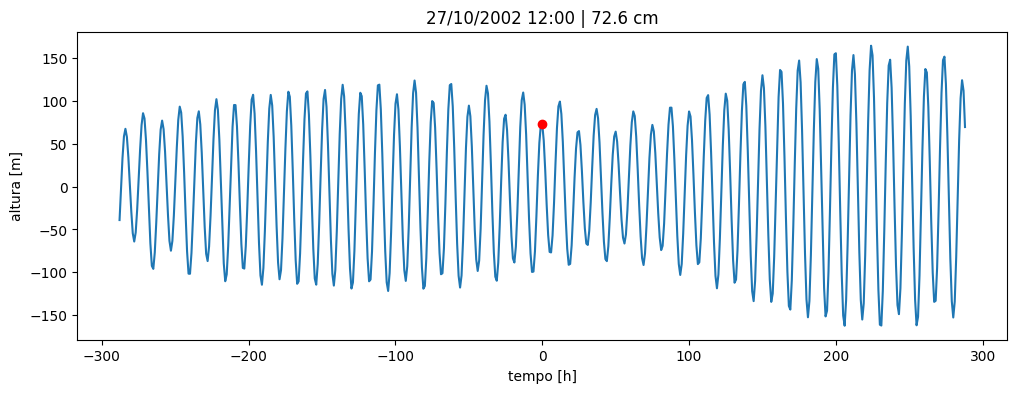

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(dt, hdt)
ax.scatter(0, hdt0, color = "red", zorder = 2)
ax.set_title(f"{utc} | {hdt0:.1f} cm")
ax.set_ylabel("altura [m]")
ax.set_xlabel("tempo [h]")

In [20]:
# lê os dados com as datas das imagens de satélite
utcs = np.loadtxt("data/processed/datas.txt", dtype = str, delimiter = ",")

In [30]:
from tqdm import tqdm

for utc in tqdm(utcs):
    # interpreta a data e muda de utc para horário local
    dt0 = parser(utc) - timedelta(hours = 3)

    # cria um série temporal entre 12 dias antes e 12 dias depois
    # com resolução de 1 hora
    dt = pd.date_range(
        start = dt0 - timedelta(days = 12),
        end = dt0 + timedelta(days = 12),
        freq = "1H",
    )

    # horas desde o tempo de referência
    dt = (dt - tref) / np.timedelta64(1, "h")
    # hora central desde o tempo de referência
    dt0h = (np.datetime64(dt0) - tref) / np.timedelta64(1, "h")

    # fax a predição da maré
    hdt0 = estimate_tide(dt0h, *amplitudes)
    hdt = estimate_tide(dt, *amplitudes)

    # muda a referência para o horário da imagem de satélite
    dt = dt - dt0h

    figname = utc.replace("/","_").replace(":","_").replace(" ","H")
    fig, ax = plt.subplots(figsize = (12, 4))
    ax.plot(dt, hdt)
    ax.scatter(0, hdt0, color = "red", zorder = 2)
    ax.set_title(f"{utc} | {hdt0:.1f} cm")
    ax.set_ylabel("altura [m]")
    ax.set_xlabel("tempo [h]")
    fig.savefig(f"img/{figname}.png", dpi = 200, bbox_inches = "tight")
    plt.close("all")

100%|██████████| 91/91 [00:24<00:00,  3.66it/s]
